In [1]:
# https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader/data
# https://discuss.pytorch.org/t/runtimeerror-multi-target-not-supported-newbie/10216/4

# Build the Dataset. We are going to generate a simple data set and then we will read it.
# Build the DataLoader.
# Build the model.
# Define the loss function and the optimizer.
# Train the model.
# Generate predictions.
# Plot the results. 

In [2]:
import math
import logging
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset


from scripts.utils.hierarchy import *
from scripts.utils.processing import *
from scripts.utils.label_utils import *
from scripts.utils.data_reading import *

logging.basicConfig(level=logging.INFO )

In [3]:
num_gpus = torch.cuda.device_count()

In [4]:
device = torch.device("cuda" if (torch.cuda.is_available() and num_gpus > 0) else "cpu")

In [5]:
device

device(type='cpu')

In [6]:
n_components = 300

In [7]:
class DatasetIterator:
    def __init__(self, datafile, catfile):
        self.datafile = datafile
        self.cat = HierarchyUtils(catfile, False, False)
        self.wn = self.cat.generate_vectors(device = device, neighbours = True)
        self.df = self.create_df()    
    
    def create_df(self):
        data = lower_dim(self.datafile, True, n_components)
        df = pd.DataFrame(columns = ["doc_id", "doc_labels", "doc_vector"])
        df["doc_labels"] = data[1]    
        df["doc_labels"] = df["doc_labels"].apply(lambda x: list(map(int, x)))  
        for i in tqdm(range(len(df))):
            df.at[i, "doc_vector"] = torch.as_tensor(data[0][i], dtype=torch.float32)
            df.at[i, "doc_id"] = i
        return df
    
    def read_df(self, idx):
        i = self.df.index[self.df["doc_id"] == idx][0]
        return self.df.at[i, "doc_vector"], self.df.at[i, "doc_labels"], i

    def __getitem__(self, _id):
        return self.read_df(_id)

    def __iter__(self):
        for _id in self.df["doc_id"]:
            yield self[_id]

class DatasetModule(Dataset):

    def __init__(self, root_location, cat_file):
        self.iter = DatasetIterator(root_location, cat_file)
        self.lmbda = self.lambda_param()
        
    def lambda_param(self):
        for n_node, n_vector in self.iter.wn[0].items():
            w_n = n_vector
            w_pi = torch.mean(list2tensor(self.iter.wn[1][n_node]), dim=0)
            norm2 = torch.norm(w_n-w_pi, 2)
            lmbda = 0.5*norm2**2
        return lmbda

    def encode_labels(self, labels):
        yin = torch.ones(len(self.iter.cat.node2id), dtype=torch.float32)*-1
        label_vector = 0
        for l in labels:
            yin[self.iter.cat.node2id[l]] = 1.
            label_vector += self.iter.wn[0][l]
        label_vector = label_vector/len(labels)
        return label_vector, yin

    def __len__(self):
        return len(self.iter.df["doc_id"])

    def __load(self, idx):
        doc_vec, doc_labels, _id = self.iter[idx]
        return doc_vec, doc_labels, _id, self.encode_labels(doc_labels)

    def __getitem__(self, idx):
        return self.__load(idx)

In [8]:
train_data = DatasetModule("rcv1.tar/RCV1_1/rcv1.train.ltc.svm", "rcv1.tar/RCV1_1/rcv1.topic.hierarchy")

35it [00:00, 69772.17it/s]
100%|█████████████████████████████████████████████████████████████████████████| 23149/23149 [00:00<00:00, 36356.41it/s]


In [9]:
test_data = DatasetModule("rcv1.tar/RCV1_1/rcv1.test.ltc.svm", "rcv1.tar/RCV1_1/rcv1.topic.hierarchy")

35it [00:00, 69871.79it/s]
100%|███████████████████████████████████████████████████████████████████████| 781265/781265 [00:22<00:00, 35502.79it/s]


In [10]:
batch_size = 64

In [11]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle = True, pin_memory=True)
# valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle = False)

In [12]:
train_iter = iter(train_loader)
doc_vec, doc_labels, _id, wn =  train_iter.next()

In [13]:
print(doc_vec.shape)
print("*"*50)
print(wn[0].shape)
print("-"*50)
print(wn[1].shape)
print("_"*50)

torch.Size([64, 300])
**************************************************
torch.Size([64, 117, 1])
--------------------------------------------------
torch.Size([64, 117])
__________________________________________________


In [14]:
# Hyper Parameters 
input_size = n_components #128 n_components
# input_size = train_data.data[0].shape[1] #2085164 

num_classes = len(train_data.iter.cat.N_all_nodes) #50312 --> n (16)
num_epochs = 15 # TRAIN IT FOR A LOT OF EPOCHS in case of lbfgs (2nd order method) else less is more
learning_rate = 0.001 #1e-4, 0.0005

In [15]:
torch.version.cuda

In [16]:
torch.backends.cudnn.version()

In [17]:
torch.backends.cudnn.benchmark = True

In [42]:
from sklearn.metrics import f1_score, precision_score, recall_score

def gather_outputs(data, model):
    y_true = []
    y_pred = []
    logging.info("Evaluating ...")
    with torch.no_grad():
        for index, (doc_vec, doc_labels, _id, label_vecs) in enumerate(data):
            
            seq = doc_vec
            label_vec = label_vecs[0].squeeze()
            yin = label_vecs[1]
            output = model(seq, label_vec, yin)
            
            if (index+1) % 500 == 0:
                print(output)

            threshold = torch.mean(output).item()
#             threshold = 0.5

            output[output >= threshold] = 1
            output[output < threshold] = -1
            
            y_pred.append(output.cpu().view(-1).numpy())
            y_true.append(yin.numpy())
            
            if (index+1) % 500 == 0:
                print(output, yin)
                test_f1 = f1_score(np.asarray(y_true), np.array(y_pred), average="micro")
                print("Index: {}/{} F1: {}".format(index+1, len(data), test_f1))
    
    y_true = np.asarray(y_true)
    y_pred = np.array(y_pred)
    test_f1 = f1_score(y_true, y_pred, average="micro")
    return y_true, y_pred

In [19]:
# Model
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, num_classes, False)
        self.exp = torch.exp
        
    def forward(self, x, labels, yin):
        x1 = self.linear1(x)
        y  = x1.mul(labels)
        exp_ = self.exp(-y*yin)
        return torch.log(1+exp_)

In [20]:
model = LogisticRegression()

In [21]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=train_data.lmbda)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

In [22]:
total_step = len(train_loader)

In [23]:
total_step

362

In [24]:
torch.cuda.empty_cache()

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
monitor = {
    "test_f1": [],
    "loss": []
}

In [27]:
for epoch in range(num_epochs):
    for doc_vec, doc_labels, _id, label_vecs in tqdm(train_loader):
        
        label_vec = label_vecs[0].squeeze()
        yin = label_vecs[1]
        
        model.zero_grad()
        output = model.forward(doc_vec, label_vec, yin)

        loss = criterion(output, label_vec)
        loss.backward()
        
        optimizer.step()
        
        monitor["loss"].append(loss.item())        

100%|████████████████████████████████████████████████████████████████████████████████| 362/362 [00:57<00:00,  6.76it/s]


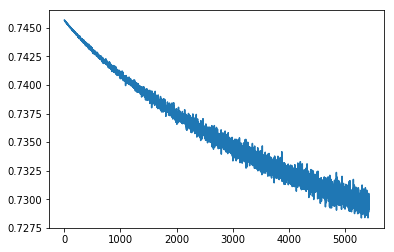

In [28]:
plt.plot(monitor["loss"]);

In [41]:
y_true, y_pred = gather_outputs(test_data, model)
test_f1 = f1_score(y_true, y_pred, average="micro")
logging.info("Test F1: {}".format(test_f1))
monitor["test_f1"].append(test_f1)

INFO:root:Evaluating ...


tensor([0.5526, 0.5121, 0.5949, 0.5205, 0.5687, 0.5314, 0.6714, 0.5188, 0.5550,
        0.7112, 0.5248, 0.5008, 0.5627, 0.5293, 0.5507, 0.4953, 0.4955, 0.5233,
        0.4933, 0.5261, 0.4634, 0.5687, 0.4840, 0.5437, 0.5043, 0.4924, 0.5319,
        0.4921, 0.4985, 0.5299, 0.4957, 0.5159, 0.4767, 0.5454, 0.4785, 0.5030,
        0.5717, 0.4814, 0.5415, 0.5049, 0.4757, 0.5105, 0.5028, 0.5362, 0.5503,
        0.5116, 0.5827, 0.4961, 0.5522, 0.5132, 0.5936, 0.5998, 0.5649, 0.5074,
        0.5680, 0.5190, 0.4731, 0.5600, 0.5005, 0.5357, 0.5593, 0.4999, 0.5569,
        0.5494, 0.5256, 0.4626, 0.5169, 0.5748, 0.4831, 0.5241, 0.5250, 0.5678,
        0.5873, 0.5589, 0.4899, 0.5741, 0.4602, 0.4680, 0.4796, 0.4704, 0.5039,
        0.6613, 0.5044, 0.5278, 0.5154, 0.4801, 0.5324, 0.5252, 0.4799, 0.5278,
        0.5210, 0.4925, 0.4634, 0.5058, 0.5083, 0.4883, 0.5453, 0.4965, 0.5678,
        0.5327, 0.5304, 0.4717, 0.5041, 0.4621, 0.4593, 0.5021, 0.5930, 0.5449,
        0.5003, 0.4921, 0.5160, 0.4894, 

TypeError: len() of unsized object

In [ ]:
plt.plot(monitor["test_f1"]);